# Stage 3 - Blocking
## Step 0: Import Required Packages
Below is a list of the python packages we used while preforming Stage 3 of the project.

In [1]:
import json
import pandas as pd
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from urllib2 import urlopen
%matplotlib inline

## Step 1: Load & Prepare Data
In this step we will __load__ our data into the python notebook and __manipulate__ the data so that it is in a format that is appropriate in order to analyze each attribute.

In [2]:
# Links to .CSV tables on Github
table_spoj = "https://raw.githubusercontent.com/KaranTalreja/CS638/master/codechef/data/\
codechef_problems.csv?token=ADx7Wd73yjTKkRvntaZDePwq1Y_KhzLVks5YMHvTwA%3D%3D"

# Load table to Pandas dataframe
table_A = pd.read_csv(urlopen(table_spoj))

In [3]:
table_A.head(2)

,time_limit,source_limit,description,index,input_text,title,problem_code,success_count,submissions_page,link,...,editorial_page,tags/0,tags/1,tags/2,tags/3,accuracy,tags/4,tags/5,tags/6,tags/7
0,3 sec,50000 Bytes,Chef is working as a programmer. His job sched...,0,The first line of each test case contains thre...,Chef and Job and Rest,CHEFJR,4,https://www.codechef.com/status/CHEFJR?sort_by...,https://www.codechef.com/problems/CHEFJR,...,http://discuss.codechef.com/problems/CHEFJR,berezin,challenge,feb16,greedy,41.18,NaN,NaN,NaN,NaN
1,8 sec,50000 Bytes,The Chef has recently sold a number of his ama...,20,The first line contains a single positive inte...,The Amazing All-In-One Cooking Machine - Chall...,ALLINONE,14,https://www.codechef.com/status/ALLINONE?sort_...,https://www.codechef.com/problems/ALLINONE,...,http://discuss.codechef.com/problems/ALLINONE,challenge,friggstad,march11,NaN,70.45,NaN,NaN,NaN,NaN


__Step 1.2:__ Manipulate Table Format & Select 10 Attributes

In [4]:
# "DateAdded" attribute as type datetime
def str_to_datetime(df):
    try:
        return datetime.strptime(df["date_added"], "%d-%m-%Y")
    except:
        pass

table_A["date_added"] = table_A.apply(str_to_datetime, axis=1)

__Step 1.3:__ Rename attributes

In [5]:
table_A["title"] = table_A["problem_code"]
table_A["input"] = table_A["input_text"]
table_A["output"] = table_A["output_text"]

__Step 1.5:__ Process filed "date_added" to create new field "days_added".
This field contains the number of days since the problem has been added. This will be
further used to caculate the number of people who solve this problem per day. This would
be used as an indicator to the level of difficulty of this problem and would help in
blocking.

In [8]:
now = datetime.strptime("2016-11-01", "%Y-%m-%d")
def process_date_added(df):
    try:
        if False == pd.isnull(df["date_added"]):
            return np.timedelta64((now - df["date_added"]), 'D').astype(float)
        else:
            return -1
    except:
        pass
    
table_A["days_added"] = table_A.apply(process_date_added, axis=1)

__Step 1.6:__ Process field "solved_by" and "days_added" to create new field "solve_rate"

In [9]:
def create_solve_rate(df):
    try:
        return df["success_count"]/df["days_added"]
    except:
        pass
    
table_A["solve_rate"] = table_A.apply(create_solve_rate, axis=1)
table_A.head(2)

,time_limit,source_limit,description,index,input_text,title,problem_code,success_count,submissions_page,link,...,tags/3,accuracy,tags/4,tags/5,tags/6,tags/7,input,output,days_added,solve_rate
0,3 sec,50000 Bytes,Chef is working as a programmer. His job sched...,0,The first line of each test case contains thre...,CHEFJR,CHEFJR,4,https://www.codechef.com/status/CHEFJR?sort_by...,https://www.codechef.com/problems/CHEFJR,...,greedy,41.18,NaN,NaN,NaN,NaN,The first line of each test case contains thre...,"For each rest period, output a single line. Th...",779.0,0.005135
1,8 sec,50000 Bytes,The Chef has recently sold a number of his ama...,20,The first line contains a single positive inte...,ALLINONE,ALLINONE,14,https://www.codechef.com/status/ALLINONE?sort_...,https://www.codechef.com/problems/ALLINONE,...,NaN,70.45,NaN,NaN,NaN,NaN,The first line contains a single positive inte...,For each test case you are to output a permuta...,2094.0,0.006686


__Step 1.7:__ Drop "solved_by", "days_added" and "date_added" fields

In [10]:
table_A = table_A[["title", "description", "input",
                   "output", "solve_rate"]]
table_A.head(2)

,title,description,input,output,solve_rate
0,CHEFJR,Chef is working as a programmer. His job sched...,The first line of each test case contains thre...,"For each rest period, output a single line. Th...",0.005135
1,ALLINONE,The Chef has recently sold a number of his ama...,The first line contains a single positive inte...,For each test case you are to output a permuta...,0.006686


__Step 1.8:__ Plot histograms and normalize the fields "difficulty" and "solve_rate"

In [11]:
# Helper function
def myround(x, base):
    return int(base * round(float(x)/base))

def numeric_histogram(table, attribute, range=[0,0], stdev=3, bins=20):
    values = table[attribute].astype(float)
    if range == [0,0]:
        range = [0, myround(values.std()*stdev, 5)]
    plt.hist(values, bins=bins, range=range)
    plt.title("%s - Histogram (%d bins)" % (attribute, bins))
    plt.show()
    summary_table = pd.DataFrame()
    summary_table["outliers"] = table[attribute][values[
            ((values - values.mean()) / values.std()).abs() > stdev
        ].index].astype(float)
    print("There are {} outliers outside of {} standard \
    deviations of {}.".format(len(summary_table), stdev, attribute))
    return summary_table.sort_values(by="outliers")

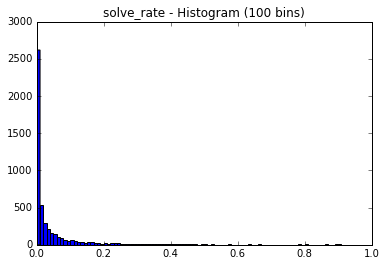

There are 5 outliers outside of 5 standard     deviations of solve_rate.


,outliers
4949,-22746.0
5199,-9738.0
3823,-2953.0
3826,-2776.0
3827,-2696.0


In [12]:
numeric_histogram(table_A, "solve_rate", range=[0,1], bins=100, stdev=5)

__Step 1.8:__ Calculate Z-score columns for "solve_rate" and "difficulty" and put them into "solve_rate_normalized" and "difficulty_normalized"

In [13]:
cols = [ "solve_rate"]
for col in cols:
    col_zscore = col + '_normalized'
    table_A[col_zscore] = (table_A[col] - table_A[col].mean())/table_A[col].std(ddof=0)
table_A.head(2)

,title,description,input,output,solve_rate,solve_rate_normalized
0,CHEFJR,Chef is working as a programmer. His job sched...,The first line of each test case contains thre...,"For each rest period, output a single line. Th...",0.005135,0.024867
1,ALLINONE,The Chef has recently sold a number of his ama...,The first line contains a single positive inte...,For each test case you are to output a permuta...,0.006686,0.024871


In [14]:
table_A = table_A[["title", "description", "input", "output", "solve_rate_normalized"]]
table_A.head(2)

,title,description,input,output,solve_rate_normalized
0,CHEFJR,Chef is working as a programmer. His job sched...,The first line of each test case contains thre...,"For each rest period, output a single line. Th...",0.024867
1,ALLINONE,The Chef has recently sold a number of his ama...,The first line contains a single positive inte...,For each test case you are to output a permuta...,0.024871


__Saving CSV file for blocking stage__ : Finished preprocessing stage up till here. Now can proceed with blocking from the csv file "spoj_blocking.csv"

In [15]:
table_A.to_csv("codechef/data/codechef_blocking.csv")